In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer 

## Data cleaning
Leggo il dataset, levo le colonne che non sono inerenti per l'addestramento del modello e lo divido il dataset in modo da avere dati da dare in pasto al modello una volta in funzione

In [33]:
file_path = "Dataset.csv"
df = pd.read_csv(file_path,encoding='utf-8')
df = df.drop(df.index[11330:19342])
x = df['Query']  # Query SQL
y = df['Label']  # Lab
x_train,x_use,y_train,y_use= train_test_split(x,y,test_size=0.2,random_state=42)
df= pd.DataFrame(x_train)
df['Label'] = y_train
df


,Query,Label
26851,SELECT fairly ( s FROM volume RIGHT JOIN,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,SELECT * FROM tone WHERE several BETWEEN '1996...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"SELECT LEFT ( CustomerName, 5 ) AS ExtractSt...",0
29587,SELECT * FROM her WHERE yes BETWEEN deep09/01/...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"select * from users where id = 1 or 1#""{ un...",1


Ora che ho il mio sub-dataset, posso procedere con la fase di data cleaninng, in primis procedo ad portare tutto in minuscolo

In [34]:
df['Query'] = df['Query'].str.lower()
df

,Query,Label
26851,select fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,select * from tone where several between '1996...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"select left ( customername, 5 ) as extractst...",0
29587,select * from her where yes between deep09/01/...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"select * from users where id = 1 or 1#""{ un...",1


elimino gli spazi bianchi iniziali e finali

In [35]:
df['Query'] = df['Query'].str.strip()
df

,Query,Label
26851,select fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,select * from tone where several between '1996...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"select left ( customername, 5 ) as extractstr...",0
29587,select * from her where yes between deep09/01/...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"select * from users where id = 1 or 1#""{ uni...",1


rimuovo il select iniziale da ogni query

In [36]:
def remove_select_at_start(query):
    if query.startswith('select'):
        return query[len('select'):].lstrip()
    else:
        return query

df['Query'] = df['Query'].apply(remove_select_at_start)
df

,Query,Label
26851,fairly ( s from volume right join,0
1866,1' in boolean mode ) order by 1--,1
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1
26246,* from tone where several between '1996-07-01'...,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1
...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0
29587,* from her where yes between deep09/01/1996sle...,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1
860,"* from users where id = 1 or 1#""{ union sele...",1


creo la feature lunghezza, dato che la maggior parte delle query con una lunghezza più grande e molto probabile che sia malevola

In [37]:
df['lunghezza'] = df['Query'].apply(len)
df

,Query,Label,lunghezza
26851,fairly ( s from volume right join,0,33
1866,1' in boolean mode ) order by 1--,1,36
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,65
26246,* from tone where several between '1996-07-01'...,0,63
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,166
...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,58
29587,* from her where yes between deep09/01/1996sle...,0,76
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,51
860,"* from users where id = 1 or 1#""{ union sele...",1,75


creo una nuova feature che mi dica quante select ci sono in una query

In [38]:
df['Select_Count'] = df['Query'].str.count('select')
df

,Query,Label,lunghezza,Select_Count
26851,fairly ( s from volume right join,0,33,0
1866,1' in boolean mode ) order by 1--,1,36,0
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,65,0
26246,* from tone where several between '1996-07-01'...,0,63,0
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,166,0
...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,58,0
29587,* from her where yes between deep09/01/1996sle...,0,76,0
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,51,0
860,"* from users where id = 1 or 1#""{ union sele...",1,75,1


Controllo se è bilanciato

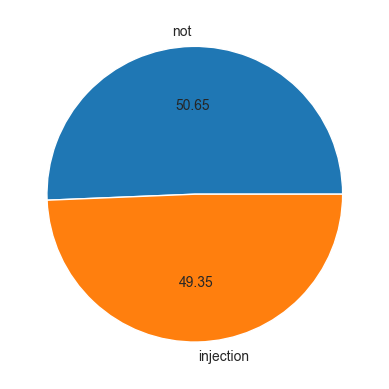

Label
0    9281
1    9044
Name: count, dtype: int64

In [39]:
plt.pie(y_train.value_counts(), labels=['not', 'injection'], autopct="%0.2f")
plt.show()
y_train.value_counts()

controllo se ho valori nulli

In [40]:
df.isnull().sum()

Query           0
Label           0
lunghezza       0
Select_Count    0
dtype: int64

visualizzo la distribuzione di query in base alla lunghezza 

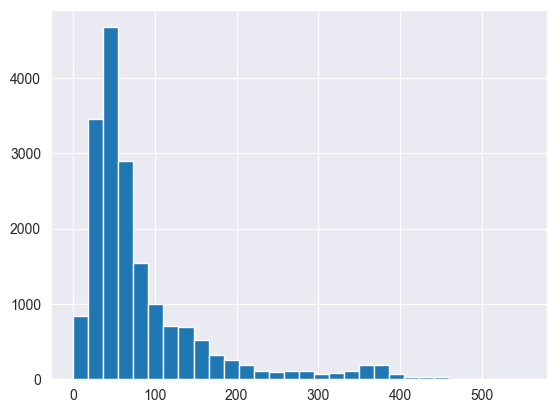

In [41]:
import matplotlib.pyplot as plt
df['lunghezza'].hist(bins=30)
plt.show()

visualizzo la distribuzione di query in base al numero di select

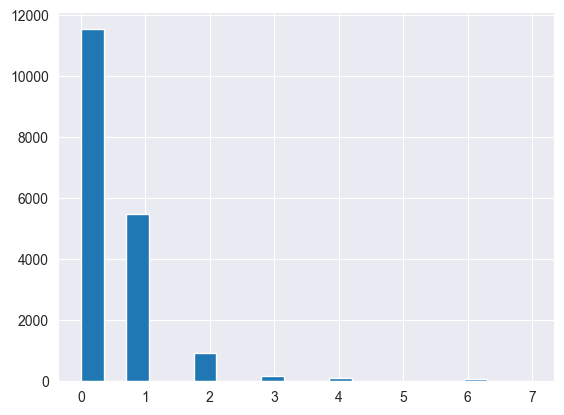

In [42]:
import matplotlib.pyplot as plt
df['Select_Count'].hist(bins=20)
plt.show()

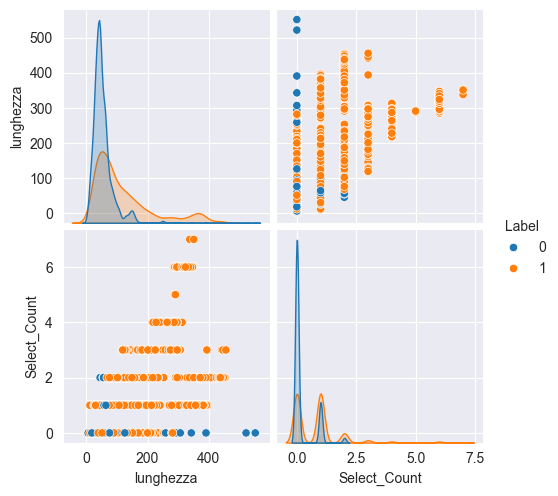

In [43]:

sns.pairplot(df, hue='Label')

normalizzo i valori numerici

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['lunghezza', 'Select_Count']] = scaler.fit_transform(df[['lunghezza', 'Select_Count']])
df

,Query,Label,lunghezza,Select_Count
26851,fairly ( s from volume right join,0,0.059783,0.000000
1866,1' in boolean mode ) order by 1--,1,0.065217,0.000000
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,0.117754,0.000000
26246,* from tone where several between '1996-07-01'...,0,0.114130,0.000000
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,0.300725,0.000000
...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,0.105072,0.000000
29587,* from her where yes between deep09/01/1996sle...,0,0.137681,0.000000
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,0.092391,0.000000
860,"* from users where id = 1 or 1#""{ union sele...",1,0.135870,0.142857


adesso tokenizzo la query

In [45]:
import nltk
nltk.download('punkt')
# Definisci una funzione per tokenizzare una query
def tokenize_query(query):
    return nltk.word_tokenize(query)

# Applica la funzione a ogni query nel tuo DataFrame
df['Query_Tokens'] = df['Query'].apply(tokenize_query)
df

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davideamoruso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Query,Label,lunghezza,Select_Count,Query_Tokens
26851,fairly ( s from volume right join,0,0.059783,0.000000,"[fairly, (, s, from, volume, right, join]"
1866,1' in boolean mode ) order by 1--,1,0.065217,0.000000,"[1, ', in, boolean, mode, ), order, by, 1, --]"
4949,"1"" and 3824 = benchmark ( 5000000,md5 ( ...",1,0.117754,0.000000,"[1, '', and, 3824, =, benchmark, (, 5000000, ,..."
26246,* from tone where several between '1996-07-01'...,0,0.114130,0.000000,"[*, from, tone, where, several, between, '1996..."
8451,"1"" where 4445 = 4445 procedure analyse ( e...",1,0.300725,0.000000,"[1, '', where, 4445, =, 4445, procedure, analy..."
...,...,...,...,...,...
19976,"left ( customername, 5 ) as extractstring fro...",0,0.105072,0.000000,"[left, (, customername, ,, 5, ), as, extractst..."
29587,* from her where yes between deep09/01/1996sle...,0,0.137681,0.000000,"[*, from, her, where, yes, between, deep09/01/..."
5390,1' ) and 4380 = 5851 and ( 'cxcl' = ...,1,0.092391,0.000000,"[1, ', ), and, 4380, =, 5851, and, (, 'cxcl, '..."
860,"* from users where id = 1 or 1#""{ union sele...",1,0.135870,0.142857,"[*, from, users, where, id, =, 1, or, 1, #, ''..."


essendo il train set già bilanciato non devo effettuare operazioni di bilanciamento quindi procedo a dividerlo tra feature e label per l'addestramento
## Addestramento
### Naive bayes

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
x=df['Query']
y=df['Label']
x_train,x_test,y_train,y_test= train_test_split(x,y ,test_size=0.2,random_state=42)
# Crea un modello basato su Multinomial Naive Bayes
model = make_pipeline(CountVectorizer(), MultinomialNB())

# Addestra il modello con i tuoi dati
model.fit(x_train,y_train)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

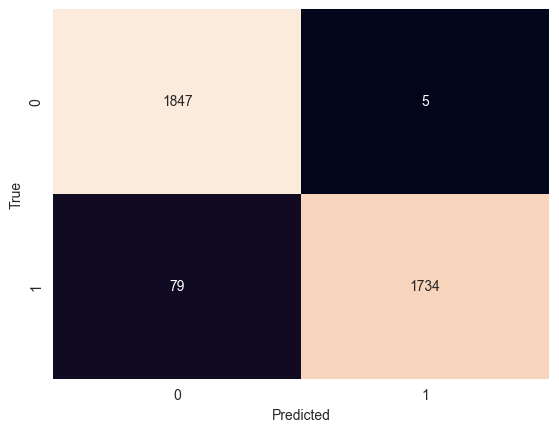

In [81]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


y_pred = model.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d",cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

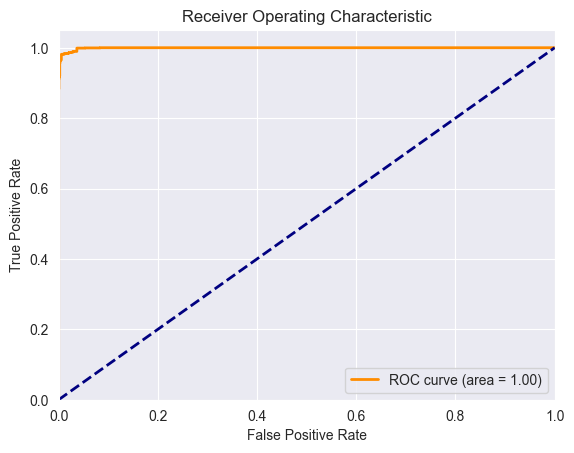

In [82]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [83]:
from sklearn.metrics import accuracy_score,precision_score
accuracy_score(y_test,y_pred)

0.9770804911323329

In [84]:
precision_score(y_test,y_pred)

0.9971247843588269

In [85]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(x_train,y_train)

ValueError: could not convert string to float: "1'+  (  select 'zjvx' where 4683  =  4683 and 6969  =    (  select 6969 from pg_sleep  (  5   )    )     )  +'"

In [86]:
y_pred = clf.predict(x_test)

NotFittedError: This BernoulliNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [87]:
accuracy_score(y_test,y_pred)

0.9770804911323329

In [88]:
precision_score(y_test,y_pred)

0.9971247843588269

In [89]:
from sklearn.naive_bayes import ComplementNB
clf = ComplementNB()
clf.fit(x_train,y_train)

ValueError: could not convert string to float: "1'+  (  select 'zjvx' where 4683  =  4683 and 6969  =    (  select 6969 from pg_sleep  (  5   )    )     )  +'"

In [90]:
y_pred = clf.predict(x_test)

NotFittedError: This ComplementNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [91]:
accuracy_score(y_test,y_pred)

0.9770804911323329

In [92]:
precision_score(y_test,y_pred)

0.9971247843588269

### Vector machines